In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

merged_set = pd.read_csv("../Data_Cleanup/outCSV/Merged_set_new.csv", index_col=0, parse_dates=["start_time", "end_time"])

merged_set = merged_set.dropna(subset=["idle_time"])

merged_set["idle_time"] = pd.to_timedelta(merged_set["idle_time"])
# Convert end_time to datetime and extract the hour
merged_set['end_time'] = pd.to_datetime(merged_set['end_time'])
merged_set['end_hour'] = merged_set['end_time'].dt.hour

# Convert idle_time to numeric (assuming it's in a format like '1h 30m')
merged_set['idle_time'] = merged_set['idle_time'].dt.total_seconds()/3600

# Use LabelEncoder to convert cloud_cover_description to numeric
le = LabelEncoder()
merged_set['cloud_cover_description'] = le.fit_transform(merged_set['cloud_cover_description'])

# Define target variable
y = merged_set['idle_time'].values

# Define features
X = merged_set.drop(['start_time', 'end_time', 'bike_id', 'idle_time',], axis=1)

C:\Users\yusuf\AppData\Local\Temp\ipykernel_91804\3863842653.py:9: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_set = pd.read_csv("../Data_Cleanup/outCSV/Merged_set_new.csv", index_col=0, parse_dates=["start_time", "end_time"])


In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1551807 entries, 0 to 1552774
Data columns (total 28 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   Unnamed: 0               1551807 non-null  int64  
 1   start_station_id         1551807 non-null  int64  
 2   start_station_lat        1551807 non-null  float64
 3   start_station_lon        1551807 non-null  float64
 4   end_station_id           1551807 non-null  int64  
 5   end_station_lat          1551807 non-null  float64
 6   end_station_lon          1551807 non-null  float64
 7   morgens                  1551807 non-null  int64  
 8   vormittags               1551807 non-null  int64  
 9   mittags                  1551807 non-null  int64  
 10  nachmittags              1551807 non-null  int64  
 11  abends                   1551807 non-null  int64  
 12  nachts                   1551807 non-null  int64  
 13  monday                   1551807 non-null 

In [9]:

# Split data into training and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.285, random_state=42)

In [11]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

loop 1: Average MSE: 25235.483209116872 Average MAE: 10.34725030989489 Average R2: 0.0710600031800801
loop 2: Average MSE: 19752.56121595913 Average MAE: 8.543065056390578 Average R2: 0.27289111125443466
loop 3: Average MSE: 6483.7189127581605 Average MAE: 6.927422625413681 Average R2: 0.7613286903885048
loop 4: Average MSE: 4209.766021953296 Average MAE: 4.877579541530865 Average R2: 0.8450348660796358
loop 5: Average MSE: 4026.74839859117 Average MAE: 4.58379059309539 Average R2: 0.8517719033321096
loop 6: Average MSE: 3687.43087345167 Average MAE: 4.194766015529042 Average R2: 0.8642624753616619
loop 7: Average MSE: 3858.97052004325 Average MAE: 4.232613721856206 Average R2: 0.8579479523767521
loop 8: Average MSE: 3771.3436603878727 Average MAE: 4.270459346200493 Average R2: 0.8611735729862356
loop 9: Average MSE: 3637.53041785788 Average MAE: 4.35957982196561 Average R2: 0.8660993543576568
loop 10: Average MSE: 3742.581935302364 Average MAE: 4.382702368268502 Average R2: 0.86223231

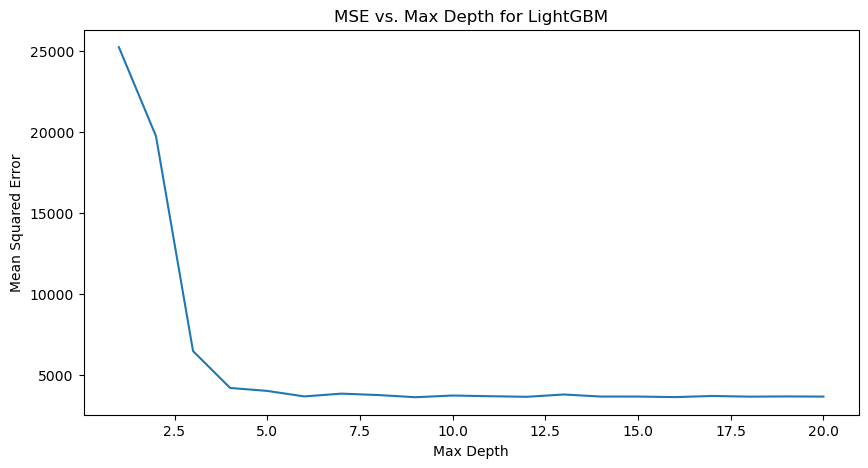

In [23]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Define the range of max_depth to test
max_depths = list(range(1, 21))

# Initialize a list to store the MSE for each max_depth
mse_values_lgbm = []

# For each max_depth, train a LightGBM model and calculate the MSE
for max_depth in max_depths:
    avg_mse = []
    avg_mae = []
    avg_r2 = []
    for i in range(1,21):

        # Train the LightGBM model
        model = lgb.LGBMRegressor(max_depth=max_depth)
        model.fit(X_train, y_train)

        # Make predictions with the LightGBM model
        preds = model.predict(X_val)
        avg_mae.append(mean_absolute_error(y_val, preds))
        avg_mse.append(mean_squared_error(y_val, preds))
        avg_r2.append(r2_score(y_val, preds))

    print(f'loop {max_depth}: Average MSE: {np.mean(avg_mse)} Average MAE: {np.mean(avg_mae)} Average R2: {np.mean(avg_r2)}')
    mse_values_lgbm.append(np.mean(avg_mse))

# Create a plot with the max_depths on the x-axis and the MSEs on the y-axis
plt.figure(figsize=(10, 5))
plt.plot(max_depths, mse_values_lgbm)
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. Max Depth for LightGBM')
plt.show()


In [26]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Define the range of max_depth to test
max_depths = list(range(1, 21))

# Initialize a list to store the MSE for each max_depth
mse_values_xgb = []

# For each max_depth, train an XGBoost model and calculate the MSE
for max_depth in max_depths:
    # Train the XGBoost model
    model = xgb.XGBRegressor(max_depth=max_depth)
    model.fit(X_train, y_train)

    # Make predictions with the XGBoost model
    preds = model.predict(X_val)


    print(f'loop {max_depth} R2: {r2_score(y_val, preds)}')
    # Calculate the MSE and store it in the list
    mse = mean_squared_error(y_val, preds)
    mse_values_xgb.append(mse)

# Create a plot with the max_depths on the x-axis and the MSEs on the y-axis
plt.figure(figsize=(10, 5))
plt.plot(max_depths, mse_values_xgb)
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. Max Depth for XGBoost')
plt.show()


loop 1 R2: 0.11350075926631542
loop 2 R2: 0.40097988600619017
loop 3 R2: 0.791598573760633
loop 4 R2: 0.8545108911478596
loop 5 R2: 0.8875984709767675
loop 6 R2: 0.8761716427868517
loop 7 R2: 0.868597845219327
loop 8 R2: 0.8606728863966273
loop 9 R2: 0.8547832276495982
loop 10 R2: 0.8511867834316007
loop 11 R2: 0.8517672330752641
loop 12 R2: 0.851941992470396
loop 13 R2: 0.8415206153760111
loop 14 R2: 0.8398279383678928
loop 15 R2: 0.8420639624110878


KeyboardInterrupt: 

Loop 1: MAE = 3.553501483522438, MSE = 12025.204303599627, R^2 = 0.5573418129156701
Loop 2: MAE = 3.7514066639713106, MSE = 13572.615165823423, R^2 = 0.5003802786537079
Loop 3: MAE = 3.9056856734716927, MSE = 13209.05582943081, R^2 = 0.5137632127546248
Loop 4: MAE = 4.071723153842732, MSE = 14662.24046177908, R^2 = 0.4602702276365641
Loop 5: MAE = 4.10723429892394, MSE = 14097.829550634719, R^2 = 0.4810466821890236
Loop 6: MAE = 4.1346982230271205, MSE = 14568.761846387219, R^2 = 0.46371125644371114
Loop 7: MAE = 4.1976374949381965, MSE = 15180.171199163447, R^2 = 0.44120474854302505
Loop 8: MAE = 4.232420840856821, MSE = 15073.768578094421, R^2 = 0.44512152119439174
Loop 9: MAE = 4.272594739027423, MSE = 15157.007633064979, R^2 = 0.4420574194762321
Loop 10: MAE = 4.327028184234572, MSE = 15285.465668684143, R^2 = 0.4373287679100736


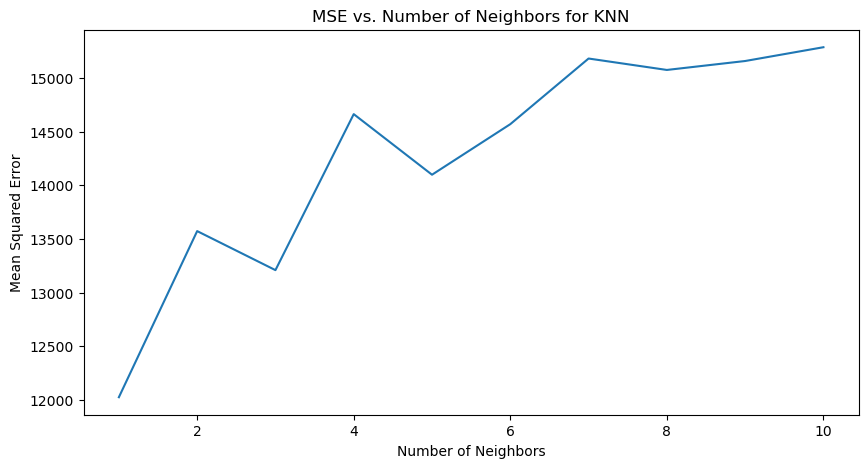

In [16]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Define the range of n_neighbors to test
n_neighbors_values = list(range(1, 11))

# Initialize a list to store the MSE for each n_neighbors
mse_values_knn = []

# For each n_neighbors, train a KNN model and calculate the MSE
for n_neighbors in n_neighbors_values:
    # Train the KNN model
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)

    # Make predictions with the KNN model
    preds = model.predict(X_val)

    # Calculate the MSE and store it in the list
    mae = mean_absolute_error(y_val, preds)
    mse = mean_squared_error(y_val, preds)
    r2= r2_score(y_val, preds)
    mse_values_knn.append(mse)
    # Print the results
    print(f'Loop {n_neighbors}: MAE = {mae}, MSE = {mse}, R^2 = {r2}')

# Create a plot with the n_neighbors on the x-axis and the MSEs on the y-axis
plt.figure(figsize=(10, 5))
plt.plot(n_neighbors_values, mse_values_knn)
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. Number of Neighbors for KNN')
plt.show()


Loop 1: MAE = 9.24656431652059, MSE = 26019.09361987886, R^2 = 0.04221462516812613
Loop 1.5: MAE = 10.25653711099381, MSE = 25985.943178260746, R^2 = 0.04343492164020568
Loop 2: MAE = 10.936190230484776, MSE = 26296.905030324895, R^2 = 0.031988146499271286
Loop 2.5: MAE = 10.018370922406321, MSE = 26390.892982405887, R^2 = 0.028528368567391493
Loop 3: MAE = 15.335102758453138, MSE = 25740.656224726292, R^2 = 0.052464146876279094
Loop 3.5: MAE = 10.229074656754603, MSE = 26705.120340010257, R^2 = 0.01696138733882191
Loop 4: MAE = 10.04557869566132, MSE = 26544.493698286024, R^2 = 0.02287419316132344


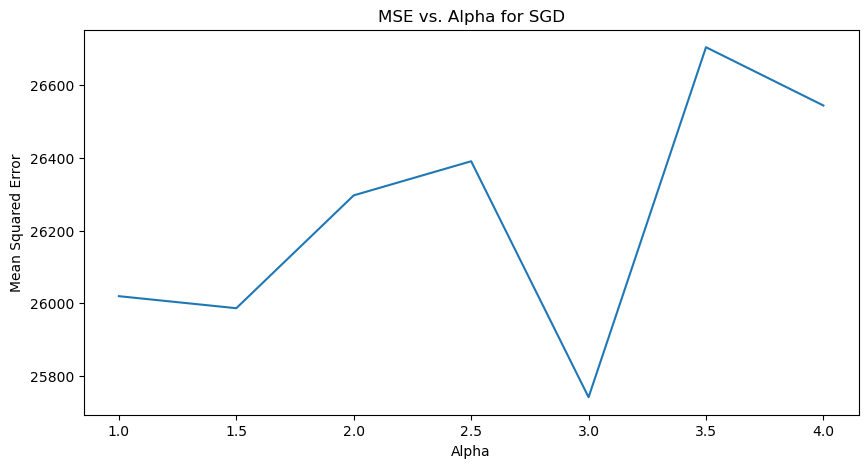

In [20]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define the range of alpha (regularization parameter) values to test
alpha_values = [1,1.5,2,2.5,3,3.5,4]

# Initialize a list to store the MSE for each alpha
mse_values_sgd = []

# For each alpha, train an SGD model and calculate the MSE
for alpha in alpha_values:
    # Train the SGD model
    model = SGDRegressor(alpha=alpha)
    model.fit(X_train, y_train)

    # Make predictions with the SGD model
    preds = model.predict(X_val)

    # Calculate the MSE and store it in the list
    mae = mean_absolute_error(y_val, preds)
    mse = mean_squared_error(y_val, preds)
    r2= r2_score(y_val, preds)
    mse_values_sgd.append(mse)
    # Print the results
    print(f'Loop {alpha}: MAE = {mae}, MSE = {mse}, R^2 = {r2}')

# Create a plot with the alpha values on the x-axis and the MSEs on the y-axis
plt.figure(figsize=(10, 5))
plt.plot(alpha_values, mse_values_sgd)
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. Alpha for SGD')
plt.show()


In [48]:
total = 0
for i in range(20):
    # Train the Decision Tree model
    tree_model = DecisionTreeRegressor(max_depth=11)
    tree_model.fit(X_train, y_train)
    # Make predictions with the Decision Tree model
    tree_preds = tree_model.predict(X_val)
    # Evaluate the Decision Tree model
    tree_mse = mean_squared_error(y_val, tree_preds)
    tree_r2 = r2_score(y_val, tree_preds)
    print("Decision Tree Model - MSE: {}, R2: {}".format(tree_mse, tree_r2))
    total += tree_r2

print("AVG: {}".format(total/20))

Decision Tree Model - MSE: 1464.9936110500314, R2: 0.9460723161465612
Decision Tree Model - MSE: 4698.933195181817, R2: 0.8270281986987176
Decision Tree Model - MSE: 2782.8641299549017, R2: 0.8975603607583529
Decision Tree Model - MSE: 4684.102056781766, R2: 0.8275741457504944
Decision Tree Model - MSE: 4014.6416511811663, R2: 0.8522175631915764
Decision Tree Model - MSE: 4698.977634502412, R2: 0.8270265628488315
Decision Tree Model - MSE: 2785.458886440174, R2: 0.8974648455244577
Decision Tree Model - MSE: 4700.375077880268, R2: 0.8269751217475765
Decision Tree Model - MSE: 2128.311042621304, R2: 0.921655026900766
Decision Tree Model - MSE: 5364.310292989588, R2: 0.8025350913545991
Decision Tree Model - MSE: 4026.5013943017775, R2: 0.8517809957739664
Decision Tree Model - MSE: 2135.9337884645724, R2: 0.9213744270231758
Decision Tree Model - MSE: 4683.553071492288, R2: 0.827594354374551
Decision Tree Model - MSE: 2802.4343845803364, R2: 0.8968399627331252
Decision Tree Model - MSE: 468

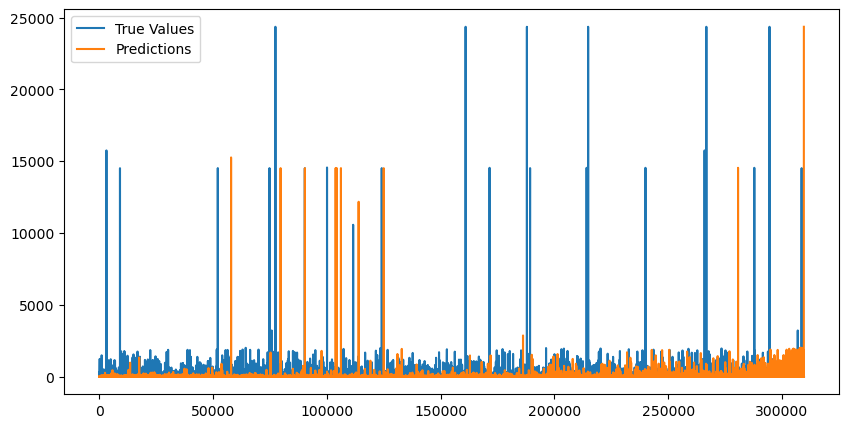

In [24]:
import matplotlib.pyplot as plt
# Convert the predictions and true values to a DataFrame
df = pd.DataFrame({
    'true_values': y_val,
    'predictions': tree_preds
})

# Sort the DataFrame by the true values
df = df.sort_values('true_values')

# Create the line plot
plt.figure(figsize=(10, 5))
plt.plot(y_val, label='True Values')
plt.plot(df['predictions'].values, label='Predictions')
plt.legend()
plt.show()

Decision Tree Model with 1 layers - MSE: 26357.44547740266, R2: 0.02975960020000412
Decision Tree Model with 2 layers - MSE: 25766.701371880663, R2: 0.05150540244827406
Decision Tree Model with 3 layers - MSE: 21404.953549339763, R2: 0.21206511810042494
Decision Tree Model with 4 layers - MSE: 10120.47216254737, R2: 0.6274566529759806
Decision Tree Model with 5 layers - MSE: 10097.12984201977, R2: 0.6283159040145676
Decision Tree Model with 6 layers - MSE: 11477.401564206906, R2: 0.5775069062793499
Decision Tree Model with 7 layers - MSE: 10482.812902671567, R2: 0.6141185764592965
Decision Tree Model with 8 layers - MSE: 8731.920664994059, R2: 0.6785704364146694
Decision Tree Model with 9 layers - MSE: 4110.883324069886, R2: 0.8486748238445092
Decision Tree Model with 10 layers - MSE: 4722.412949843374, R2: 0.8261638885906092
Decision Tree Model with 11 layers - MSE: 2788.519763167551, R2: 0.8973521720006803
Decision Tree Model with 12 layers - MSE: 4024.301747675709, R2: 0.85186196667

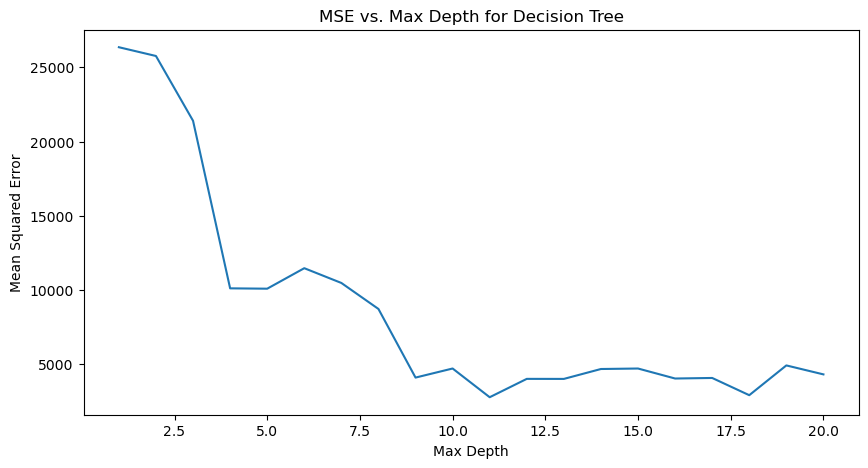

In [47]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define the range of depths to test
max_depths = list(range(1, 21))

# Initialize a list to store the MSE for each depth
mse_values = []

# For each depth, train a Decision Tree and calculate the MSE
for max_depth in max_depths:
    # Train the Decision Tree model
    tree_model = DecisionTreeRegressor(max_depth=max_depth)
    tree_model.fit(X_train, y_train)

    # Make predictions with the Decision Tree model
    tree_preds = tree_model.predict(X_val)

    # Calculate the MSE and store it in the list
    mse = mean_squared_error(y_val, tree_preds)
    mse_values.append(mse)
    tree_r2 = r2_score(y_val, tree_preds)
    print("Decision Tree Model with {} layers - MSE: {}, R2: {}".format(max_depth, mse, tree_r2))

# Create a plot with the depths on the x-axis and the MSEs on the y-axis
plt.figure(figsize=(10, 5))
plt.plot(max_depths, mse_values)
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. Max Depth for Decision Tree')
plt.show()

# SLOW

In [ ]:


from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define the range of C values to test
C_values = [100, 10, 1, 0.1]

# Initialize a list to store the MSE for each C value
mse_values_svr = []

# For each C value, train an SVR with RBF kernel and calculate the MSE
for C in C_values:
    print(f'loop {C}')
    # Train the SVR model
    model = SVR(kernel='rbf', C=C)
    print(f'step {C} 2')

    model.fit(X_train, y_train)
    print(f'step {C} 3')
    # Make predictions with the SVR model
    preds = model.predict(X_val)
    print(f'step {C} 4')
    # Calculate the MSE and store it in the list
    mse = mean_squared_error(y_val, preds)
    print(f'step {C} 5')
    mse_values_svr.append(mse)
    print(f'step {C} 6')

# Create a plot with the C values on the x-axis and the MSEs on the y-axis
plt.figure(figsize=(10, 5))
plt.plot(C_values, mse_values_svr)
plt.xlabel('C Value')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. C Value for SVR with RBF Kernel')
plt.show()


loop 100
step 100 2


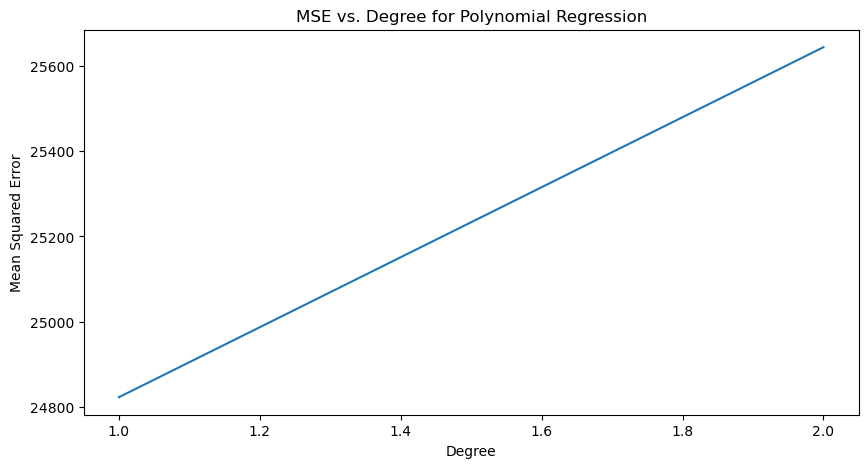

In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define the range of degrees to test
degrees = list(range(1, 3))

# Initialize a list to store the MSE for each degree
mse_values_poly = []

# For each degree, train a Polynomial Regression model and calculate the MSE
for degree in degrees:
    # Train the Polynomial Regression model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)

    # Make predictions with the Polynomial Regression model
    preds = model.predict(X_val)

    # Calculate the MSE and store it in the list
    mse = mean_squared_error(y_val, preds)
    mse_values_poly.append(mse)

# Create a plot with the degrees on the x-axis and the MSEs on the y-axis
plt.figure(figsize=(10, 5))
plt.plot(degrees, mse_values_poly)
plt.xlabel('Degree')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. Degree for Polynomial Regression')
plt.show()


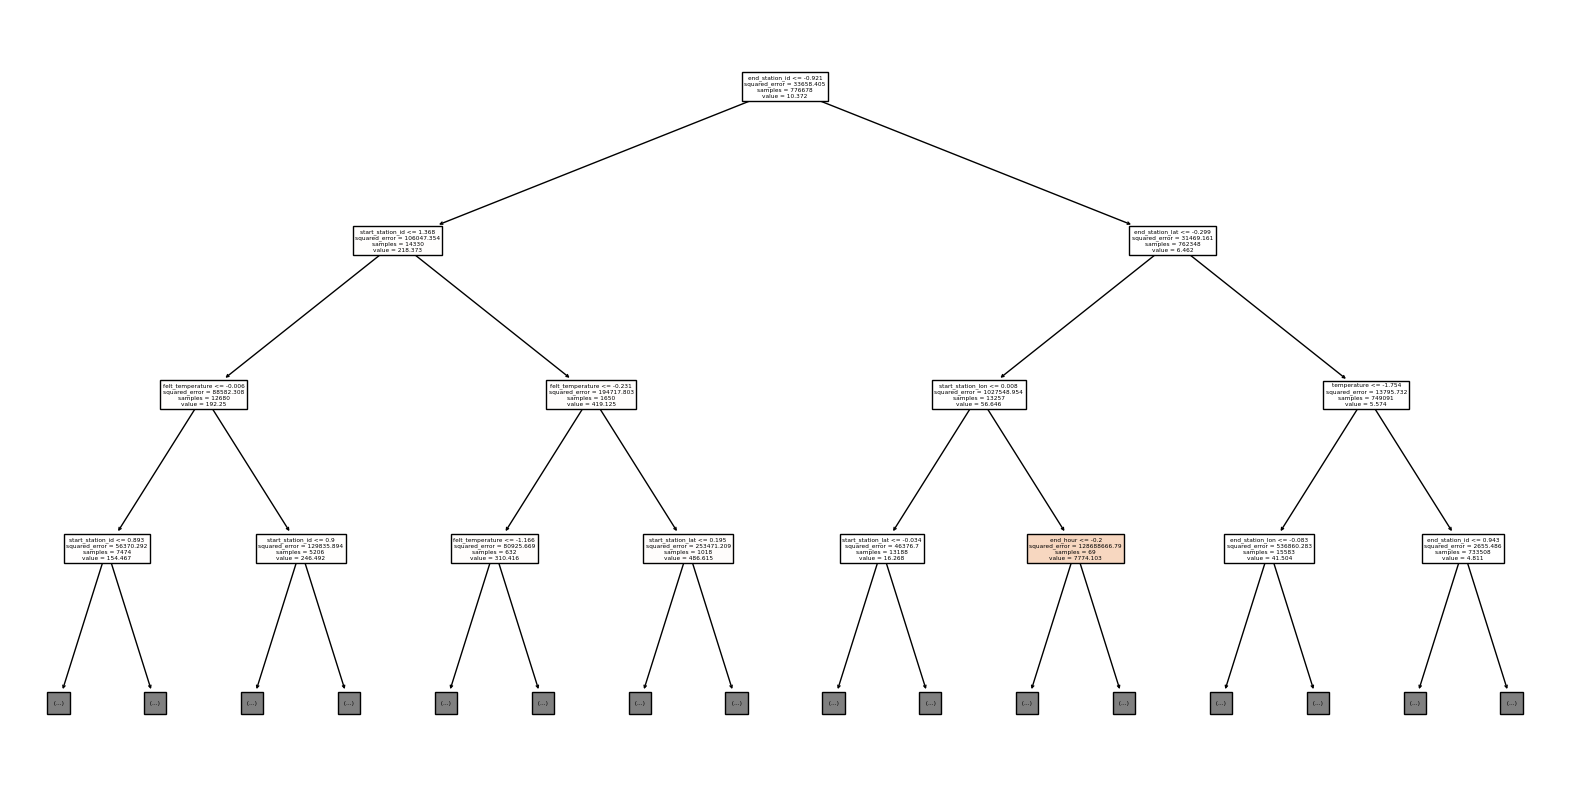

In [25]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
# Plot the decision tree
plt.figure(figsize=(20,10))  # Set the figure size
plot_tree(tree_model, filled=True, feature_names=X_train_val.columns, max_depth=3)
plt.show()